In [1]:
import warnings, math, itertools, json, logging, os
from hashlib import md5

import numpy as np
import pandas as pd

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

%load_ext autoreload
%autoreload 1


In [2]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    fbeta_score,
    make_scorer,
    precision_recall_curve
)

f2_score = make_scorer(fbeta_score, beta=2)

METRICS = {
    "Accuracy": "accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "AUC": "roc_auc",
    "F1 Score": "f1",
    "F2 Score": f2_score,
}

def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "F2 Score": fbeta_score(y_true, y_pred, beta=2),
    }

In [3]:
from cross_validation import cross_validate_parallel
from sklearn.model_selection import train_test_split
%aimport cross_validation

def spotCheckCV(models, X, y, cv=3, pretty=True):
    models = {'Model':models} if type(models) != dict else models
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    r = cross_validate_parallel(models, X_train, y_train, scoring=METRICS, cv=cv)
    return pd.concat([pd.DataFrame(r[_]).assign(model=_) for _ in r.keys()]).groupby('model').mean()   

In [40]:
from dataset import SCIData, SCICols
%aimport dataset
#SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_readmission().omit_vbg().save()
sci = SCIData.load('data/sci_processed.h5').derive_critical_event(within=2)

## LR with NEWS only

In [5]:
X, y = sci.mandate_news().xy(x=SCICols.news_data_raw, dtype=float, outcome="CriticalEvent")

In [6]:
from sklearn.linear_model import LogisticRegression
models = {
    'LR': LogisticRegression(random_state=42),
    'LR_Balanced': LogisticRegression(class_weight='balanced', random_state=42)
}
spotCheckCV(models, X, y)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LR,0.435507,0.031244,0.982311,0.557528,0.045441,0.818121,0.083757,0.055616
LR_Balanced,0.425095,0.041656,0.852968,0.078048,0.668723,0.818850,0.139777,0.266021


In [8]:
def get_news_target_ratio(X, y):
    y_pred = X.c_NEWS_score >= 7
    return precision_score(y, y_pred)/recall_score(y, y_pred)

target_ratio = get_news_target_ratio(*sci.mandate_news().xy(outcome="CriticalEvent"))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
log = LogisticRegression(class_weight='balanced', random_state=42).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_train, log.predict_proba(X_train)[:, 1])
closest = thresholds[np.abs(precision/recall-target_ratio).argmin()]
y_pred = np.where(log.predict_proba(X_test)[:, 1] > closest, 1, 0)

c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\stybl\AppData\Local\Temp\ipykernel_3308\663792480.py:13: RuntimeWarning: divide by zero encountered in true_divide
  closest = thresholds[np.abs(precision/recall-target_ratio).argmin()]


In [ ]:
pd.DataFrame(get_metrics(y_test, y_pred), index=['LR_Calibrated'])

,Accuracy,Precision,Recall,F1 Score,F2 Score
LR_Calibrated,0.972249,0.246914,0.28169,0.263158,0.273973


## XGB with all features

In [261]:
from xgboost import XGBClassifier
def test_xgb(X, y):
    X = X.drop(['ReadmissionBand', 'AgeBand', 'AandEPresentingComplaint'], axis=1).apply(lambda x:x.replace({True:1.0, False:0.0}))
    X[X.select_dtypes(include=object).columns] = X.select_dtypes(include=object).astype('category')
    return spotCheckCV({
        'XGB_Unweighted':XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=1),
        'XBG_Weighted':XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=round(y.shape[0]/y.sum())) # Weight=56
    }, X, y)

In [25]:
print('Baseline:')
test_xgb(*sci.omit_redundant().omit_ae().impute_blood().raw_news().mandate_news().augment_hsmr().encode_ccs_onehot().xy(outcome='CriticalEvent'))

Baseline:


,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XBG_Weighted,9.532823,0.295813,0.973584,0.333802,0.480758,0.901800,0.393856,0.441701
XGB_Unweighted,9.460602,0.292126,0.982394,0.525591,0.163329,0.924687,0.248044,0.189110


In [262]:
X, y = sci.omit_redundant().omit_ae().impute_blood().raw_news().mandate_news().augment_hsmr().encode_ccs_onehot().xy(outcome='CriticalEvent', dropna=True)
X = X.drop(['ReadmissionBand', 'AgeBand', 'AandEPresentingComplaint'], axis=1).apply(lambda x:x.replace({True:1.0, False:0.0}))
X[X.select_dtypes(include=object).columns] = X.select_dtypes(include=object).astype('category')
cat_cols = [X.columns.get_loc(_) for _ in X.select_dtypes(include='category').columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [226]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC

spotCheckCV({
    'XGB': Pipeline(steps=[
        ('clf', XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=1))
    ]),
    'XGB_Balanced': Pipeline(steps=[
        ('clf', XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=56))
    ]),
    'XGB_Under': ImbPipeline(steps=[
        ('under', RandomUnderSampler(sampling_strategy=0.1)),
        ('clf', XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=1))
    ]),
    'XGB_SMOTE': ImbPipeline(steps=[
        ('smote', SMOTENC(cat_cols)),
        ('clf', XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=1))
    ]),
    'XGB_UnderOver': ImbPipeline(steps=[
        ('oversampling', SMOTENC(cat_cols, sampling_strategy=0.1)),
        ('undersampling', RandomUnderSampler(sampling_strategy=0.5)),
        ('clf', XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=1))
    ]),
}, X, y)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,17.461128,0.359290,0.982773,0.510636,0.207794,0.920963,0.294890,0.235598
XGB_Balanced,17.737105,0.348876,0.975146,0.339800,0.457791,0.887798,0.389849,0.427876
XGB_SMOTE,26.997482,0.281184,0.982618,0.498952,0.228896,0.924220,0.313717,0.256645
XGB_Under,14.133968,0.333255,0.974145,0.344131,0.539774,0.928224,0.419979,0.484353
XGB_UnderOver,18.721237,0.335839,0.974342,0.345309,0.531648,0.924486,0.418583,0.479765


In [47]:
model = XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=round(y.shape[0]/y.sum())).fit(X_train, y_train)

<AxesSubplot:>

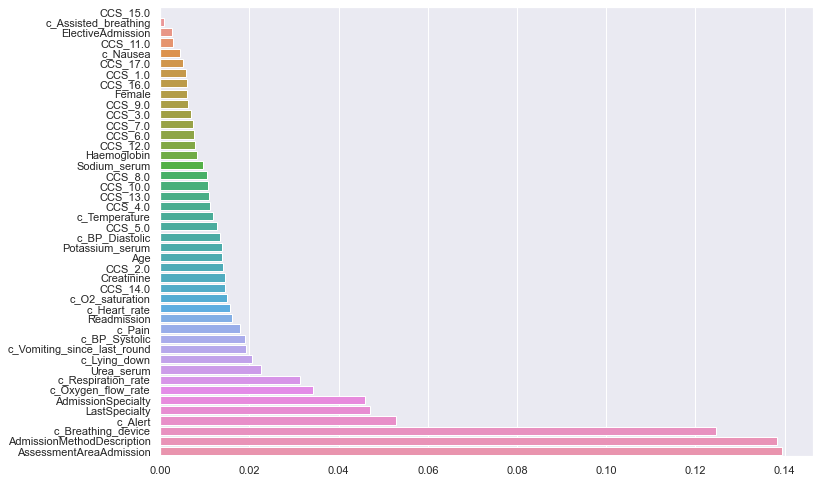

In [48]:
sorted_idx = model.feature_importances_.argsort()
sns.barplot(x=model.feature_importances_[sorted_idx], y=X.columns[sorted_idx])

In [268]:
r = cross_validate( XGBClassifier(tree_method='approx', enable_categorical=True, scale_pos_weight=1), X.head(1000), y[:1000], scoring='roc_auc')

0.8733887094293186

In [279]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=XGBClassifier(
        tree_method='approx', enable_categorical=True, 
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    r = cross_validate(clf, X_train.head(10000), y_train[:10000], cv=5, n_jobs=5, scoring='roc_auc')
    score = r['test_score'].mean()
    print(f"SCORE: {score}")
    return {'loss': -score, 'status': STATUS_OK }

In [277]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE: 0.5                                             
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                          
SCORE: 0.5                                                          
SCORE: 0.5                                                          
SCORE: 0.5                                                          
SCORE: 0.5                                              

In [242]:
X[X.select_dtypes(include='category').columns] = X.select_dtypes(include='category').apply(lambda x: x.cat.codes)

In [245]:
from sklearn.ensemble import HistGradientBoostingClassifier
spotCheckCV({'hist':HistGradientBoostingClassifier(categorical_features=cat_cols)}, X, y)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
hist,0.752633,0.11711,0.982378,0.483823,0.223201,0.934616,0.305401,0.250125


In [251]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
spotCheckCV({
    'lbgm': LGBMClassifier()
}, X, y)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
lbgm,0.591026,0.223905,0.98266,0.500723,0.219995,0.930505,0.305251,0.247631


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

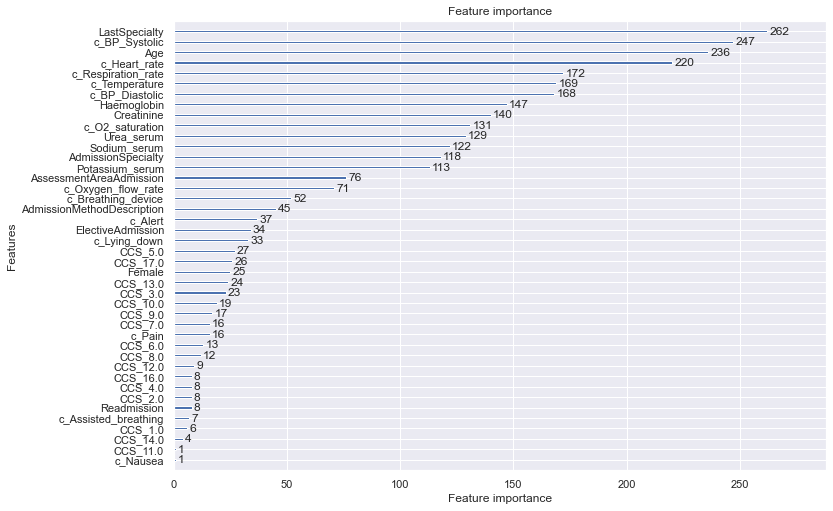

In [252]:
lgb.plot_importance(LGBMClassifier().fit(X, y))

In [253]:
X, y = sci.omit_redundant().omit_ae().impute_blood().raw_news().mandate_news().augment_hsmr().xy(outcome='CriticalEvent', dropna=True)
X = X.drop(['ReadmissionBand', 'AgeBand', 'AandEPresentingComplaint'], axis=1).apply(lambda x:x.replace({True:1.0, False:0.0}))
X[X.select_dtypes(include=object).columns] = X.select_dtypes(include=object).astype('category')
cat_cols = [X.columns.get_loc(_) for _ in X.select_dtypes(include='category').columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [254]:
spotCheckCV({
    'lbgm': LGBMClassifier()
}, X, y)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
lbgm,0.162153,0.062485,0.982148,0.609771,0.230852,0.92642,0.333398,0.263134


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

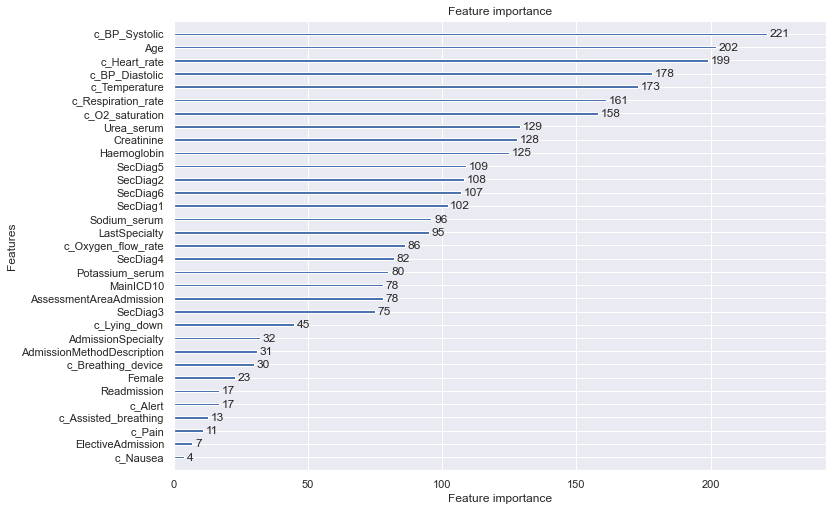

In [255]:
lgb.plot_importance(LGBMClassifier().fit(X, y))

## RF

In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
X, y = sci.omit_redundant().omit_ae().impute_blood().raw_news().mandate_news().augment_hsmr().encode_ccs_onehot().mandate_diagnoses().xy(outcome='CriticalEvent', dropna=True)
X = X.drop(['ReadmissionBand', 'AgeBand', 'AandEPresentingComplaint'], axis=1).apply(lambda x:x.replace({True:1.0, False:0.0}))
X[X.select_dtypes(include=object).columns] = X.select_dtypes(include=object).astype('category')
X = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), X.select_dtypes(include='category').columns)
], remainder='passthrough').fit_transform(X)

In [222]:
spotCheckCV({
    'RF': Pipeline(steps=[
        ('clf', RandomForestClassifier())
    ]),
    'RF_Balanced': Pipeline(steps=[
        ('clf', RandomForestClassifier(class_weight='balanced_subsample'))
    ]),
    'RF_Under': ImbPipeline(steps=[
        ('under', RandomUnderSampler(sampling_strategy=0.5)),
        ('clf', RandomForestClassifier())
    ]),
    'RF_UnderLess': ImbPipeline(steps=[
        ('under', RandomUnderSampler(sampling_strategy=0.1)),
        ('clf', RandomForestClassifier())
    ]),
    'RF_SMOTE': ImbPipeline(steps=[
        ('smote', SMOTE()),
        ('clf', RandomForestClassifier())
    ]),
    'RF_UnderOver': ImbPipeline(steps=[
        ('oversampling', SMOTE(sampling_strategy=0.1)),
        ('undersampling', RandomUnderSampler(sampling_strategy=0.5)),
        ('clf', RandomForestClassifier())
    ]),
}, X, y)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
RF,12.460412,0.817458,0.983083,0.637468,0.058444,0.915047,0.107025,0.071409
RF_Balanced,11.599754,0.873534,0.982970,0.653470,0.043014,0.915463,0.080580,0.052873
RF_SMOTE,21.181878,0.690089,0.982463,0.475895,0.094157,0.913048,0.156983,0.112096
RF_Under,0.926862,1.426822,0.925649,0.158551,0.759733,0.927977,0.262295,0.431912
RF_UnderLess,2.754398,1.398336,0.977232,0.375877,0.469976,0.927338,0.417592,0.447487
RF_UnderOver,4.027929,1.283501,0.975160,0.341806,0.464277,0.922724,0.393706,0.433204


In [259]:
from sklearn.preprocessing import OneHotEncoder
X, y = sci.omit_redundant().omit_ae().impute_blood().raw_news().mandate_news().augment_hsmr().encode_ccs_onehot().mandate_diagnoses().xy(outcome='CriticalEvent', dropna=True)
X = X.drop(['ReadmissionBand', 'AgeBand', 'AandEPresentingComplaint'], axis=1).apply(lambda x:x.replace({True:1.0, False:0.0}))
X[X.select_dtypes(include=object).columns] = X.select_dtypes(include=object).astype('category')
X = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(), X.select_dtypes(include='category').columns)
], remainder='passthrough').fit_transform(X)

In [230]:
from sklearn.ensemble import IsolationForest
spotCheckCV({
    'iso': IsolationForest(),
    'iso2': IsolationForest(contamination=1/56)
}, X, y.map({True: -1, False:1}))

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
iso,5.124241,3.309920,0.909437,0.989283,0.917779,0.798866,0.952190,0.931241
iso2,7.597948,2.971337,0.969916,0.984997,0.984376,0.801629,0.984686,0.984500


In [176]:
from sklearn.ensemble import IsolationForest
spotCheckCV({
    'iso': IsolationForest(),
    'iso2': IsolationForest(contamination=1/56)
}, X, y.map({True: -1, False:1}))

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
iso,0.354088,0.356648,0.937282,0.992968,0.943240,0.850992,0.967448,0.952773
iso2,0.614441,0.314993,0.973392,0.989612,0.983404,0.848518,0.986498,0.984639


In [260]:
from sklearn.linear_model import SGDOneClassSVM
spotCheckCV({'SGDOSVM': SGDOneClassSVM()}, X, y.map({True: -1, False:1}))

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
SGDOSVM,0.005207,0.010402,0.980598,0.980598,1.0,0.492004,0.990204,0.996058
